# Software profesional en Acústica 2024-25 (M2i)

*This notebook contains a modification of the notebook [FEM_Helmholtz_equation](https://github.com/spatialaudio/computational_acoustics/blob/master/FEM_Helmholtz_equation.ipynb), created by Sascha Spors, Frank Schultz, Computational Acoustics Examples, 2018. The text/images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/). The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

First, we need to install on the fly FEniCS 2019.1.0 using the [FEM on Colab](https://fem-on-colab.github.io/packages.html) install script:

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# Numerical Solution of the Helmholtz Equation using the Finite Element Method

This notebook illustrates the numerical solution of the wave equation for harmonic excitation using the so called [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM). The method aims at an approximate solution by subdividing the area of interest into smaller parts with simpler geometry, linking these parts together and applying methods from the calculus of variations to solve the problem numerically. The FEM is a well established method for the numerical approximation of the solution of partial differential equations (PDEs). The solutions of PDEs are often known analytically only for rather simple geometries. FEM based simulations allow to gain insights into other more complex cases.

## Problem Statement

The inhomogeneous linear [wave equation](https://en.wikipedia.org/wiki/Wave_equation) is given as

\begin{equation*}
\Delta p(\boldsymbol{x}, t) - \frac{1}{c^2} \frac{\partial^2}{\partial t^2} p(\boldsymbol{x}, t) = - f(\boldsymbol{x}, t) ,
\end{equation*}

where $p(\boldsymbol{x}, t)$ denotes the sound pressure at position $\boldsymbol{x}$, $c$ the speed of sound and $q(\boldsymbol{x}, t)$ the inhomogeneity.
For an harmonic excitation $f(\boldsymbol{x}, t) = \Re \{ F(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} \}$ with frequency $\omega = 2 \pi f$ we choose the Ansatz $p(\boldsymbol{x}, t) = \Re \{ P(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} \}$ for the sound pressure.
Introduction of the complex quantities into the wave equation yields

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} = - F(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} ,
\end{equation*}

and canceling out the $\mathrm{e}^{\mathrm{j} \omega t}$ terms yields the [Helmholtz equation](https://en.wikipedia.org/wiki/Helmholtz_equation)

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega) + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega) = - F(\boldsymbol{x}, \omega) .
\end{equation*}

We aim for a numerical solution of the Helmholtz equation on the domain $\Omega$ with respect to the homogeneous Dirichlet boundary condition

\begin{equation*}
P(\boldsymbol{x}, \omega) = 0 \qquad \text{for } \boldsymbol{x}\in \partial \Omega 
\end{equation*}

or the homogeneous Neumann boundary condition

\begin{equation*}
\frac{\partial}{\partial\boldsymbol{n}} P(\boldsymbol{x}, \omega) = 0 \qquad \text{for } \boldsymbol{x}\in \partial \Omega,
\end{equation*}

where $\partial \Omega$ denotes the boundary of $\Omega$.

## Variational Formulation

The FEM is based on expressing the partial differential equation (PDE) to be solved in its [variational](https://en.wikipedia.org/wiki/Calculus_of_variations) or weak form.
The first step towards this formulation is to multiply the Helmholtz equation by the test function $Q(\boldsymbol{x}, \omega)$

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega)  + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega)  Q(\boldsymbol{x}, \omega) = - F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) ,
\end{equation*}

followed by integration over the domain $V$

\begin{equation*}
\int_{\Omega} \Delta P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x}  + \frac{\omega^2}{c^2} \int_{\Omega} P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} = - \int_{\Omega} F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} ,
\end{equation*}

where $\,\mathrm{d}\boldsymbol{x}$ denotes a suitably chosen differential element for integration.
Application of [Green's first identity](https://en.wikipedia.org/wiki/Green%27s_identities) yields

\begin{align*}
{-}&\int_{\Omega} \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x}  + \int_{\partial\Omega} Q(\boldsymbol{x}, \omega) \frac{\partial}{\partial\boldsymbol{n}}  P(\boldsymbol{x}, \omega)\,\mathrm{d}\boldsymbol{s}\\
&+ \frac{\omega^2}{c^2} \int_{\Omega} P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} = - \int_{\Omega} F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} .
\end{align*}

This way the differential order of the first integral is lowered which is advisable for application of the FEM.
The second integral vanishes as 

* the variation formulation requires $Q(\boldsymbol{x}, \omega) = 0$ on $\partial \Omega$ where $P(\boldsymbol{x}, \omega)$ is known - here by the pure Dirichlet boundary condition - or
* due to a pure homogeneous Neumann boundary condition $\frac{\partial}{\partial\boldsymbol{n}} P(\boldsymbol{x}, \omega)$ on $\partial \Omega$. 

This results in the variational/weak formulation of the Helmholtz equation

\begin{equation*}
{-} \int_{\Omega} \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x}  + \frac{\omega^2}{c^2} \int_{\Omega} P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} = - \int_{\Omega} F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} .
\end{equation*}

It is common to express the integral equation above in terms of the bilinear $a(P, Q)$ and linear $L(Q)$ forms 

\begin{equation*}
a(P, Q) = \frac{\omega^2}{c^2} \int_{\Omega} P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} - \int_{\Omega} \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} ,
\end{equation*}

\begin{equation*}
L(Q) = - \int_{\Omega} F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \,\mathrm{d}\boldsymbol{x} ,
\end{equation*}

where

\begin{equation*}
a(P, Q) = L(Q) \qquad \forall Q.
\end{equation*}

## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs.
Its high-level Python interface `dolfin` is used in the following to define the problem and compute its solution.
The implementation is based on the variational formulation derived above.
It is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$.
The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.
We limit ourselves to real-valued $P(\boldsymbol{x}, \omega)$ due to the assumption of Dirichlet or Neumann boundary conditions.

For the subsequent examples the solution of the inhomogeneous wave equation for a point source $F(\boldsymbol{x}) = \delta(\boldsymbol{x}-\mathbf{x_s})$ at position $\mathbf{x_s}$ is computed using the FEM.
A function is defined for this purpose, accompanied by a plotting routine for the resulting sound field.

In [6]:
import dolfin
import mshr
import matplotlib.pyplot as plt
%matplotlib inline


def FEM_Helmholtz(mesh, frequency, xs, neumann_bc=True, c=343):
    '''numerical solution of the Helmholtz equation using the FEM'''
    
    # squared wavenumber
    k2 = dolfin.Constant(2*dolfin.pi*frequency/c)**2
    
    # define function space
    V = dolfin.FunctionSpace(mesh, "CG", 2)

    # define boundary conditions
    if neumann_bc:
        bcs = None
    else:
        bcs = dolfin.DirichletBC(V, dolfin.Constant(0), "on_boundary")
    
    # define variational problem
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    a = k2 * dolfin.inner(u, v) * dolfin.dx - dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx
    L = dolfin.Constant(0) * v * dolfin.dx
    
    A, b = dolfin.assemble_system(a, L, bcs)
    
    # define inhomogenity
    delta = dolfin.PointSource(V, xs, -1)  # to account for negative sign in inhomogeneity
    delta.apply(b)

    # compute solution
    u = dolfin.Function(V)
    dolfin.solve(A, u.vector(), b)

    return u


def plot_soundfield(u):
    '''plot solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = dolfin.plot(u)
    plt.title(r'$P(\mathbf{x}, \omega)$')
    plt.xlabel(r'$x$ / m')
    plt.ylabel(r'$y$ / m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

### Sound Field in a Rectangular Room with Sound-Hard Boundaries

The two-dimensional sound field in a rectangular room whose height is very small compared to the wavelength and with rigid boundaries (Neumann boundary condition) is computed for the frequency $f=120$ Hz and source position $x_s = (1.2,3.2)$ m.

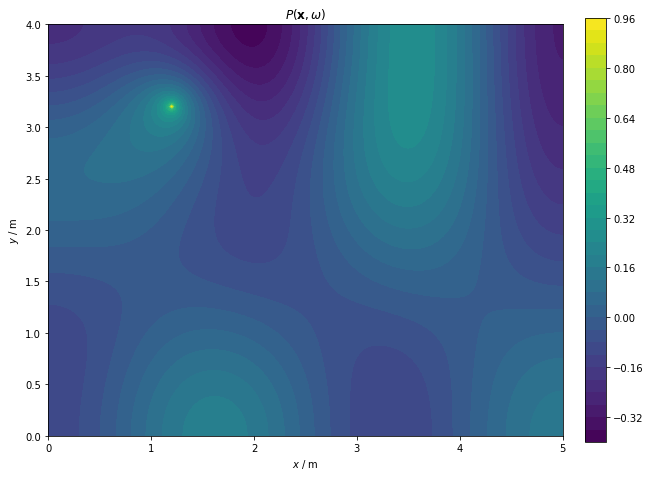

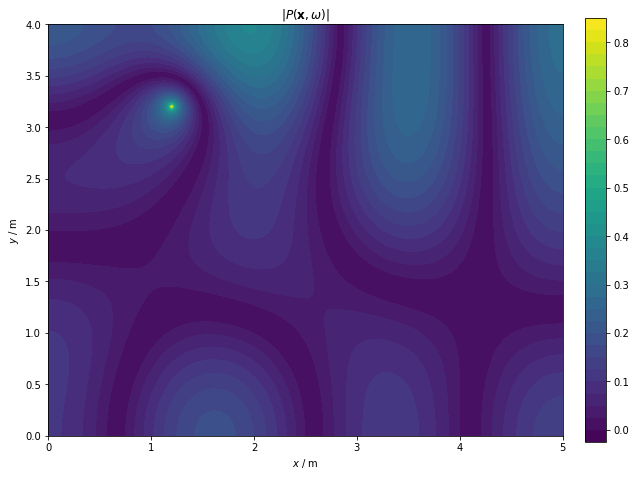

In [8]:
# define geometry and mesh
mesh = dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(5,4), 200, 200, "right/left")

# compute solution
u = FEM_Helmholtz(mesh, 120, dolfin.Point(1.2,3.2))

# plot sound field
plot_soundfield(u)
plot_soundfield(abs(u))
plt.title(r'$|P(\mathbf{x}, \omega)|$');

### Sound Field in Two Coupled Rectangular Rooms

The two-dimensional sound field in two coupled rectangular rooms with sound-hard boundaries (Neumann boundary condition) is computed for the frequency $f=120$ Hz and source position $x_s = (2,0.5)$ m. First the geometry is defined and plotted, for which the mesh is generated with a low number of elements for ease of illustration. A higher resolution is then used for the simulations.

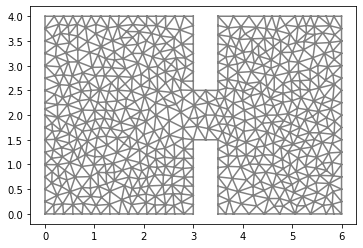

In [9]:
# define geometry and mesh
domain = mshr.Rectangle(dolfin.Point(0, 0), dolfin.Point(3,4)) + \
         mshr.Rectangle(dolfin.Point(3, 1.5), dolfin.Point(3.5, 2.5)) + \
         mshr.Rectangle(dolfin.Point(3.5, 0), dolfin.Point(6, 4))
mesh2 = mshr.generate_mesh(domain, 20)

dolfin.plot(mesh2);

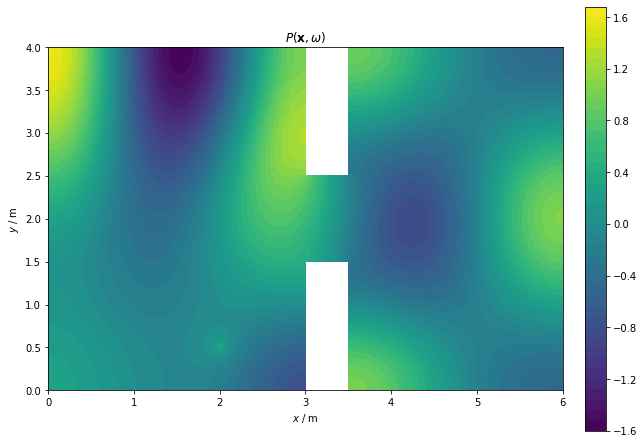

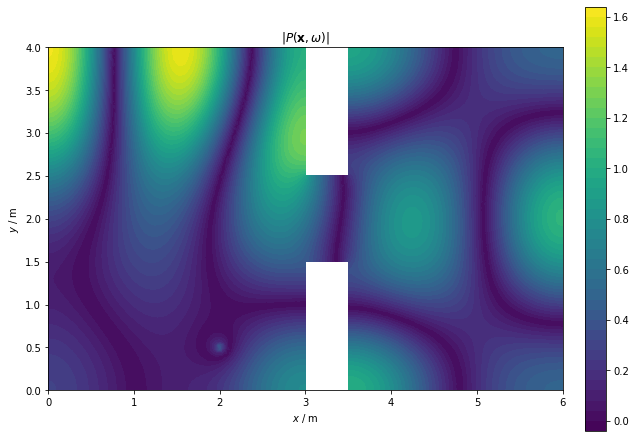

In [11]:
# compute solution
mesh2 = mshr.generate_mesh(domain, 100)
u = FEM_Helmholtz(mesh2, 120, dolfin.Point(2, .5))

# plot sound field
plot_soundfield(u)
plot_soundfield(abs(u))
plt.title(r'$|P(\mathbf{x}, \omega)|$');

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).